# Basic PCSF workflow against our synthetic datasets

In [1]:
%pylab inline
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from matplotlib_venn import venn3, venn3_circles, venn2

import sys
sys.path.insert(0, "/Users/alex/Documents/OmicsIntegrator2/src")
from graph import *

Populating the interactive namespace from numpy and matplotlib


# I. Prepare input instance from cases

In [3]:
dataset = pd.read_csv('/Users/alex/Documents/proteomics/synthetic_proteomics/generated_data/ludwig_svd_normals/hsa04110_inbiomap_exp.csv', index_col=0)
dataset.head()

,ZNF91,NDEL1,ELAVL1,SUMO1,SUMO3,CHMP5,UBC,HTT,E2F4,ACP5,...,SPANXN4,ZNF605,SERPINB10,ANKAR,RRH,DHH,CYSLTR1,ZNF268,COL23A1,MEDAG
hsa04110,0.0,0.014856,0.264810,0.109797,-0.976005,0.173769,0.0,0.285756,0.288839,-0.231566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.228736,0.089442,0.339065,-0.597546,0.040049,0.0,-0.098450,0.073976,-0.494193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.715740,-0.143526,-0.480106,0.125846,0.284645,-0.0,0.021132,-0.115910,-0.016950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,-0.0,-0.383979,0.359009,0.394243,-0.387827,-0.281805,0.0,-0.922308,0.340674,-0.278771,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
negative,0.0,-0.023037,0.196800,-0.292508,0.165186,0.105207,0.0,-0.521385,-0.194466,-0.234121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
instance = abs(dataset.loc['hsa04110'].mean() - dataset.loc['negative'].mean())
instance.head()

ZNF91     0.000000
NDEL1     0.012221
ELAVL1    0.082732
SUMO1     0.034982
SUMO3     0.059264
dtype: float64

In [5]:
instance = instance[instance > 0.0001]
len(instance)

8966

In [6]:
instance = pd.DataFrame(instance)
instance.head()

,0
NDEL1,0.012221
ELAVL1,0.082732
SUMO1,0.034982
SUMO3,0.059264
CHMP5,0.023084


In [7]:
instance.reset_index(inplace=True)
instance.columns = ['name', 'prize']
instance.head()

,name,prize
0,NDEL1,0.012221
1,ELAVL1,0.082732
2,SUMO1,0.034982
3,SUMO3,0.059264
4,CHMP5,0.023084


In [8]:
instance.to_csv('hsa04110_inbiomap_exp.pcsf.prizes', sep='\t', index=False, header=True)

# II. Prepare Graph

In [10]:
inbiomap_experimentally = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/interactomes/InBioMap/inbiomap_exp.normalized.cleaned.connected.tsv', sep='\t')
inbiomap_experimentally.head()

,protein1,protein2,confidence
0,ZNF91,NDEL1,0.147
1,ZNF91,ELAVL1,0.146
2,ZNF91,SUMO1,0.155
3,ZNF91,SUMO3,0.155
4,ZNF91,CHMP5,0.159


In [11]:
inbiomap_experimentally['cost'] = 1.4 - inbiomap_experimentally['confidence']

In [13]:
inbiomap_experimentally[['protein1', 'protein2', 'cost']].to_csv('inbiomap_temp.tsv', sep='\t', header=False, index=False) # need to remove headers

# III. Run PCSF

In [10]:
graph = Graph('inbiomap_temp.tsv', {"b": 1.0741})

In [11]:
prize_file = 'hsa04110_inbiomap_exp.pcsf.prizes'
graph.prepare_prizes(prize_file)
graph.prizes

04:42:21 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
04:42:21 - Graph: INFO - []
04:42:21 - Graph: INFO - Members of the prize file not present in the interactome:
04:42:21 - Graph: INFO - []


array([ 0.        ,  0.06226778,  0.01300805, ...,  0.        ,
        0.        ,  0.        ])

In [12]:
vertex_indices, edge_indices = graph.pcsf()
len(vertex_indices)

236

In [13]:
forest, augmented_forest = graph.output_forest_as_networkx(vertex_indices, edge_indices)
forest

/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/alex/Documents/proteomics/venv/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is dep

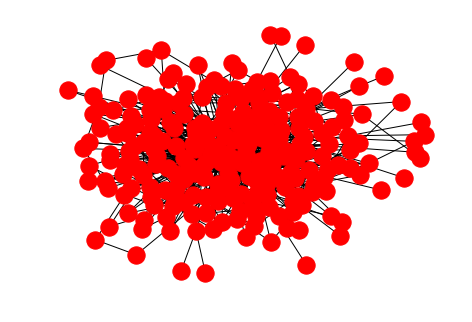

In [14]:
nx.draw_spring(augmented_forest)


# IV. Bayesian Optimization

In [14]:
from bayes_opt import BayesianOptimization

# use sklearn's default parameters for theta and random_start
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 2}

In [15]:
graph = Graph('inbiomap_temp.tsv', {})
graph.prepare_prizes('hsa04110_inbiomap_exp.pcsf.prizes')

11:08:01 - Graph: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
11:08:01 - Graph: INFO - []
11:08:01 - Graph: INFO - Members of the prize file not present in the interactome:
11:08:01 - Graph: INFO - []


In [16]:
pathways = pd.read_pickle('/Users/alex/Documents/proteomics/synthetic_proteomics/data_generation/KEGG_df.filtered.with_correlates.pickle')
ground_truth_pathway_genes, correlates = pathways.loc[pd.IndexSlice[:,:,['hsa04110']], ['genes', 'correlates']].values[0]
ground_truth_pathway_genes = set(ground_truth_pathway_genes)

In [22]:
def Recall(truth, pred):    
    return len(truth & pred) / float(len(truth)+1)
    
def Precision(truth, pred):
    return len(truth & pred) / float(len(pred)+1)

def F1(truth, pred):
#     precision = Precision(truth, pred)
#     recall = Recall(truth, pred)
#     F_other = precision + recall
    return venn2([truth, pred], set_labels=['truth', 'pred'])
#     F1 = 2 * (precision * recall) / (precision + recall + 1)
#     return F_other

def Eval(**params):
    _, (vertex_indices, _) = graph._eval_pcsf(params)
    selected_nodes = set(graph.nodes[vertex_indices])
    return F1(ground_truth_pathway_genes, selected_nodes)


In [18]:
bo = BayesianOptimization(Eval, {'a': (1000, 100000), 'b':(1, 1.1), 'w':(0, 7)})

In [19]:
bo.maximize(init_points=10, n_iter=90, acq="ucb", kappa=2, **gp_params)

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |         a |         b |         w | 
    1 | 00m00s |    0.50800 | 49089.3913 |    1.0735 |    1.1853 | 
    2 | 00m00s |    0.00000 | 46171.9130 |    1.0234 |    2.4343 | 
    3 | 00m01s |    0.00000 | 12352.5127 |    1.0760 |    3.1545 | 
    4 | 00m00s |    0.00000 | 56551.6875 |    1.0995 |    4.6455 | 
    5 | 00m00s |    0.00000 | 22457.6198 |    1.0304 |    3.7061 | 
    6 | 00m00s |    0.00000 | 75462.0266 |    1.0560 |    3.9684 | 
    7 | 00m00s |    0.68267 | 11487.1491 |    1.0895 |    1.1198 | 
    8 | 00m00s |    0.00000 | 79105.4918 |    1.0904 |    5.7921 | 
    9 | 00m00s |    0.00000 | 55092.9400 |    1.0364 |    3.4907 | 
   10 | 00m00s |    0.76431 | 54921.2081 |    1.0231 |    0.3867 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         a |         b |         w | 
   11 | 00m01s | 

In [20]:
print(bo.res['max'])

{'max_val': 0.87333333333333341, 'max_params': {'a': 51773.435001572449, 'b': 1.000957438119751, 'w': 0.48252914670384772}}


In [21]:
bo.maximize(n_iter=20, acq='ei', xi=1e-4, **gp_params)

Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         a |         b |         w | 
  101 | 00m08s |    0.00000 | 8479.5427 |    1.0140 |    6.7018 | 
  102 | 00m04s |    0.00000 | 57183.3248 |    1.0336 |    6.9859 | 
  103 | 00m04s |    0.00000 | 82744.2357 |    1.0621 |    6.3964 | 
  104 | 00m04s |    0.00000 | 16681.1145 |    1.0825 |    4.7807 | 
  105 | 00m04s |    0.00000 | 83138.2201 |    1.0647 |    4.3385 | 
  106 | 00m04s |    0.50800 | 51391.7538 |    1.0560 |    1.4814 | 
  107 | 00m04s |    0.00000 | 51371.8242 |    1.0310 |    6.9534 | 
  108 | 00m04s |    0.50800 | 51413.4603 |    1.0835 |    1.1741 | 
  109 | 00m04s |    0.00000 | 51436.6985 |    1.0162 |    5.8086 | 
  110 | 00m05s |    0.61181 | 6824.4775 |    1.0996 |    0.3542 | 
  111 | 00m05s |    0.68267 | 6806.0055 |    1.0511 |    0.8487 | 
  112 | 00m05s |    0.00000 | 6787.3360 |    1.0581 |    4.2057 | 
  113 | 00m06s |    0.00000 | 681

# V. Hand-optimization

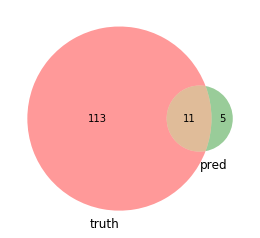

In [26]:
Eval(a=5000, b=2, w=4)

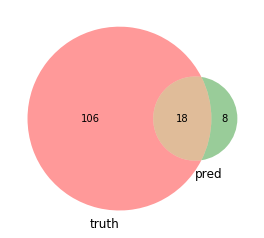

In [27]:
Eval(a=5000, b=3, w=4)

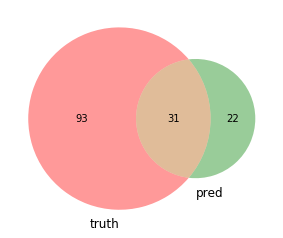

In [28]:
Eval(a=5000, b=4, w=4)

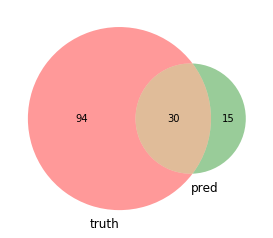

In [31]:
Eval(a=2000, b=3, w=4)

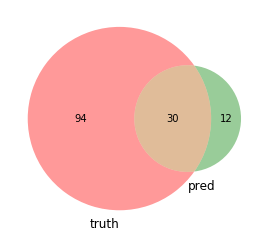

In [34]:
Eval(a=2000, b=3, w=6)

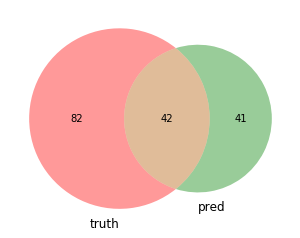

In [41]:
Eval(a=2000, b=4, w=7)

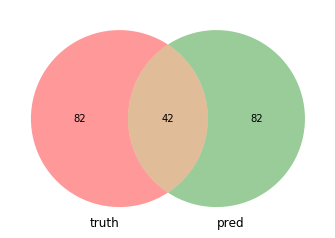

In [43]:
Eval(a=1500, b=4, w=7)